In [1]:
import os
import csv

import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

from tqdm import tqdm

In [2]:
MODEL_NAME = 'Tacotron2'
CPU_RUN = True

In [3]:
from ESDDataset import ESDDataset

d = ESDDataset(dataset_dir='./data/Emotion Speech Dataset')

In [4]:
d.df["mel_text_pair"] = d.df['audio_file_path']+'|'+d.df['transcription']+'|'+d.df['emotion_class'].apply(lambda x: str(x))

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(d.df, test_size=0.2)

train.to_csv(path_or_buf='./data/train_mel_text_pairs.txt', columns=['mel_text_pair'], index=False, header=False, quoting=csv.QUOTE_NONE, escapechar='\\')
test.to_csv(path_or_buf='./data/test_mel_text_pairs.txt', columns=['mel_text_pair'], index=False, header=False, quoting=csv.QUOTE_NONE, escapechar='\\')

In [4]:
import argparse
from train import parse_args
from models import model_parser

args = argparse.ArgumentParser()
parser = parse_args(args)
parser = model_parser(MODEL_NAME, parser)

In [5]:
# n_emotions = len(d.emotion_label_encoder.classes_)
n_emotions = 5

In [6]:
args = parser.parse_args(f'--epochs 10 -lr 1e-4 -bs 2 -m Tacotron2 -o ./models/ --sampling-rate 16000 --n-emotions {n_emotions}'.split())

In [7]:
from tacotron2.data_function import TextMelLoader

train_dataset = TextMelLoader(dataset_path='', audiopaths_and_text='./data/train_mel_text_pairs.txt', args=args)
val_dataset = TextMelLoader(dataset_path='', audiopaths_and_text='./data/test_mel_text_pairs.txt', args=args)

In [17]:
from torch.utils.data import DataLoader
import data_functions

collate_fn = data_functions.get_collate_function(
        MODEL_NAME, args.n_frames_per_step)
train_loader = DataLoader(train_dataset, num_workers=1, shuffle=False,
                              sampler=None,
                              batch_size=args.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)

In [8]:
train_dataset[0][1].shape

torch.Size([80, 286])

In [18]:
def adjust_learning_rate(iteration, epoch, optimizer, learning_rate,
                         anneal_steps, anneal_factor, rank):

    p = 0
    if anneal_steps is not None:
        for i, a_step in enumerate(anneal_steps):
            if epoch >= int(a_step):
                p = p+1

    if anneal_factor == 0.3:
        lr = learning_rate*((0.1 ** (p//2))*(1.0 if p % 2 == 0 else 0.3))
    else:
        lr = learning_rate*(anneal_factor ** p)

    if optimizer.param_groups[0]['lr'] != lr:
        print(step=(epoch, iteration), data={'learning_rate changed': str(optimizer.param_groups[0]['lr'])+" -> "+str(lr)})

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [19]:
def validate(model, criterion, valset, epoch, batch_iter, batch_size,
             world_size, collate_fn, distributed_run, perf_bench, batch_to_gpu, amp_run):
    """Handles all the validation scoring and printing"""
    
    model.eval()
    with torch.no_grad():
        val_loader = DataLoader(valset, num_workers=1, shuffle=False,
                                sampler=None,
                                batch_size=batch_size, pin_memory=False,
                                collate_fn=collate_fn,
                                drop_last=(True if perf_bench else False))

        val_loss = 0.0
        num_iters = 0
        val_items_per_sec = 0.0
        for i, batch in enumerate(val_loader):

            x, y, num_items = batch_to_gpu(batch)
            #AMP upstream autocast
            with torch.cuda.amp.autocast(enabled=amp_run):
                y_pred = model(x)
                loss = criterion(y_pred, y)

            reduced_val_loss = loss.item()
            reduced_num_items = num_items.item()
            val_loss += reduced_val_loss
            
            num_iters += 1

        val_loss = val_loss/num_iters
        val_items_per_sec = val_items_per_sec/num_iters


        # print(step=(epoch,), data={'val_loss': val_loss})
        # print(step=(epoch,), data={'val_items_per_sec': val_items_per_sec})

        return val_loss, val_items_per_sec

In [20]:
def save_checkpoint(model, optimizer, scaler, epoch, config, output_dir,
                    model_name, local_rank, world_size):

    random_rng_state = torch.random.get_rng_state().cuda()
    cuda_rng_state = torch.cuda.get_rng_state(local_rank).cuda()

    random_rng_states_all = [torch.empty_like(random_rng_state) for _ in range(world_size)]
    cuda_rng_states_all = [torch.empty_like(cuda_rng_state) for _ in range(world_size)]

    # if world_size > 1:
    #     dist.all_gather(random_rng_states_all, random_rng_state)
    #     dist.all_gather(cuda_rng_states_all, cuda_rng_state)
    # else:
    random_rng_states_all = [random_rng_state]
    cuda_rng_states_all = [cuda_rng_state]

    random_rng_states_all = torch.stack(random_rng_states_all).cpu()
    cuda_rng_states_all = torch.stack(cuda_rng_states_all).cpu()

    if local_rank == 0:
        checkpoint = {'epoch': epoch,
                      'cuda_rng_state_all': cuda_rng_states_all,
                      'random_rng_states_all': random_rng_states_all,
                      'config': config,
                      'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(),
                      'scaler': scaler.state_dict()}

        checkpoint_filename = "checkpoint_{}_{}.pt".format(model_name, epoch)
        checkpoint_path = os.path.join(output_dir, checkpoint_filename)
        print("Saving model and optimizer state at epoch {} to {}".format(
            epoch, checkpoint_path))
        torch.save(checkpoint, checkpoint_path)

        symlink_src = checkpoint_filename
        symlink_dst = os.path.join(
            output_dir, "checkpoint_{}_last.pt".format(model_name))
        if os.path.exists(symlink_dst) and os.path.islink(symlink_dst):
            print("Updating symlink", symlink_dst, "to point to", symlink_src)
            os.remove(symlink_dst)

        os.symlink(symlink_src, symlink_dst)

In [8]:
import models
import loss_functions

model_config = models.get_model_config(MODEL_NAME, args)
model = models.get_model(MODEL_NAME, model_config, CPU_RUN,
                         uniform_initialize_bn_weight=not args.disable_uniform_initialize_bn_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate,
                                 weight_decay=args.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=args.amp)

criterion = loss_functions.get_loss_function(MODEL_NAME, sigma=None)

In [28]:
def train(output_dir: str):
    writer = SummaryWriter(output_dir)
    
    # valset = data_functions.get_data_loader(
    #         MODEL_NAME, args.dataset_path, args.validation_files, args)
    batch_to_gpu = data_functions.get_batch_to_gpu(MODEL_NAME)

    local_rank, world_size = args.rank, args.world_size
    distributed_run = world_size > 1

    epoch = [0]
    start_epoch = epoch[0]
    iteration = 0
    
    epoch_loss = 0
    log_len = len(train_loader) // 30

    for epoch in tqdm(range(start_epoch, args.epochs)):
        # used to calculate avg items/sec over epoch
        reduced_num_items_epoch = 0
        
        num_iters = 0
        reduced_loss = 0
        
        for i, batch in enumerate(tqdm(train_loader)):
            adjust_learning_rate(iteration, epoch, optimizer, args.learning_rate,
                                        args.anneal_steps, args.anneal_factor, local_rank)

            model.zero_grad()
            x, y, num_items = batch_to_gpu(batch)

            y_pred = model(x)
            loss = criterion(y_pred, y)

            reduced_loss = loss.item()
            reduced_num_items = num_items.item()
            if np.isnan(reduced_loss):
                raise Exception("loss is NaN")
            

            # print(f"step={(epoch,i)}", f"data='train_loss':{reduced_loss}")
            epoch_loss += loss
            num_iters += 1

            # accumulate number of items processed in this epoch
            reduced_num_items_epoch += reduced_num_items

            if args.amp:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), args.grad_clip_thresh)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), args.grad_clip_thresh)
                optimizer.step()

            model.zero_grad(set_to_none=True)
            
            # print(f"step={(epoch,i)}", f"data=train_loss: {reduced_loss}")
            # print(step=(epoch,), data={'train_epoch_time': epoch_time})

            if i % log_len == 0:
                writer.add_scalar("Step Loss Train", loss, i)

            val_loss, val_items_per_sec = validate(model, criterion, val_dataset, epoch,
                                                iteration, args.batch_size,
                                                world_size, collate_fn,
                                                distributed_run, args.bench_class=="perf-train",
                                                batch_to_gpu,
                                                args.amp)
            writer.add_scalar("Validation Loss Train", val_loss, epoch+1)


            # if (epoch % args.epochs_per_checkpoint == 0) and (args.bench_class == "" or args.bench_class == "train"):
            #     save_checkpoint(model, optimizer, scaler, epoch, model_config,
            #                     args.output, args.model_name, local_rank, world_size)
                
            # print(f"step=tuple({(epoch,i)})", f"data=val_loss: {val_loss}")
            # print(f"step=tuple({(epoch,i)})", f"data=train_loss:{reduced_loss}")

    writer.add_scalar("Epoch Loss Train", epoch_loss, epoch+1)
    epoch_loss = 0

In [ ]:
train()

In [99]:
from inference import load_and_setup_model

checkpoint = './models/checkpoint_Tacotron2_79.pt'
# model = load_and_setup_model(MODEL_NAME, parser, checkpoint=checkpoint, fp16_run=False, cpu_run=CPU_RUN)
# state_dict = torch.load(checkpoint, map_location=torch.device('cpu'))['state_dict']
# model.load_state_dict(state_dict)

checkpoint = 'https://api.ngc.nvidia.com/v2/models/nvidia/tacotron2pyt_fp32/versions/1/files/nvidia_tacotron2pyt_fp32_20190306.pth'
state_dict = torch.hub.load_state_dict_from_url(checkpoint, map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)

model.eval()

Tacotron2(
  (embedding): Embedding(148, 512)
  (emotion_embedding): Embedding(5, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNo

In [57]:
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', pretrained=False)
checkpoint = torch.hub.load_state_dict_from_url('https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth', map_location='cpu')

state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}
waveglow.load_state_dict(state_dict)

waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda' if not CPU_RUN else 'cpu')
waveglow.eval()

Using cache found in /Users/AjayMoturi/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/opt/homebrew/anaconda3/envs/deep_learning/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

In [100]:
from inference import prepare_input_sequence
import inference

text = ["In which fox loses a tail and its elder sister finds one", "They'd never know I'd regular ran away.", "Perhaps you think that is a queer title for this chapter.", "This used to be Jerry's occupation.", "Confess that you opened the thirteenth door."]
sequences, lengths = prepare_input_sequence(text, cpu_run=CPU_RUN)

emotions = torch.tensor([4,4,3,4,1])
# emotions = torch.tensor([d.emotion_label_encoder.transform(['Surprise'])[0], d.emotion_label_encoder.transform(['Angry'])[0]])

with torch.no_grad():
    mel, _, _ = model.infer(sequences, emotions, lengths)
    audio = waveglow.infer(mel)

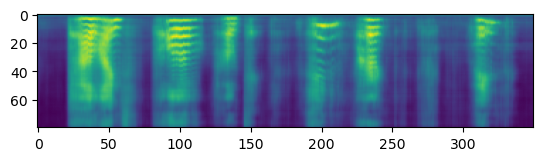

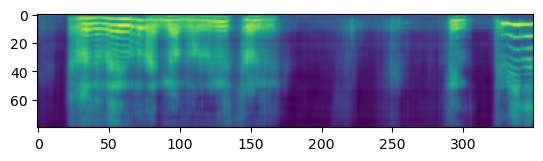

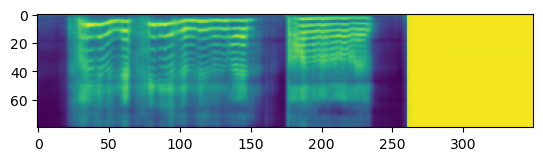

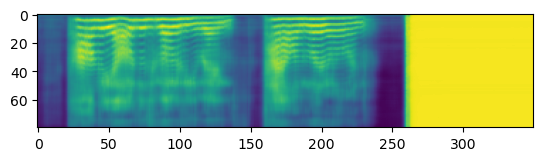

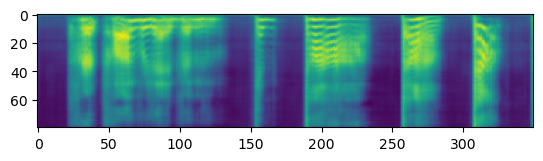

In [95]:
import matplotlib.pyplot as plt

for i in range(mel.size(0)):
    plt.figure()
    plt.imshow(mel[i,:,:350])

In [101]:
from IPython.display import Audio
from scipy.io.wavfile import write

audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

# write("audio.wav", rate, audio_numpy)
Audio(audio_numpy, rate=rate)

In [102]:
from IPython.display import Audio
from scipy.io.wavfile import write

audio_numpy = audio[1].data.cpu().numpy()
rate = 22050

# write("audio.wav", rate, audio_numpy)
Audio(audio_numpy, rate=rate)

In [103]:
from IPython.display import Audio
from scipy.io.wavfile import write

audio_numpy = audio[2].data.cpu().numpy()
rate = 22050

# write("audio.wav", rate, audio_numpy)
Audio(audio_numpy, rate=rate)

In [104]:
from IPython.display import Audio
from scipy.io.wavfile import write

audio_numpy = audio[3].data.cpu().numpy()
rate = 22050

# write("audio.wav", rate, audio_numpy)
Audio(audio_numpy, rate=rate)

In [105]:
from IPython.display import Audio
from scipy.io.wavfile import write

audio_numpy = audio[4].data.cpu().numpy()
rate = 22050

# write("audio.wav", rate, audio_numpy)
Audio(audio_numpy, rate=rate)